# Mengimpor *Library*

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from google.colab import files

import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
seed = 4353
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Mengunggah Dataset

In [ ]:
# Upload Dataset
data = files.upload()

Saving ReviewBarber_Dataset.csv to ReviewBarber_Dataset.csv


In [ ]:
# Read Dataframe
df = pd.read_csv('ReviewBarber_Dataset.csv')
df

,review_text,review_rating
0,Awal potong disini pelayanan masih bagus. Mung...,1
1,Barber yang paling ga worth it yang pernah say...,1
2,Tempat potong rambut yang cukup oke dengan har...,5
3,"Antrian ga fair, sering kesela sama orang2 yg ...",2
4,Enak potongan di tukang pangkas rambut di desa...,1
...,...,...
884,pelayanan yang baik,3
885,Mantap,4
886,Tukang cukur yang bagus,5
887,Langganan saya,5


# Data *Preprocessing* + EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_text    889 non-null    object
 1   review_rating  889 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.0+ KB


In [ ]:
# Identifying missing value
df.isnull().sum()

review_text      0
review_rating    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Review Rating')

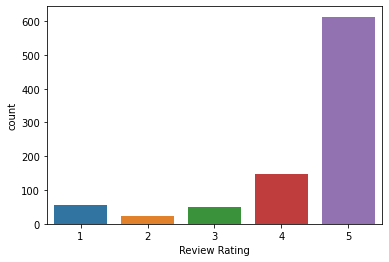

In [ ]:
# Plot review_rating
sns.countplot(df.review_rating)
plt.xlabel('Review Rating')

In [ ]:
# Replacing numerical values with categorical values to reduce the classes to review_rating

df['review_rating'] = df.review_rating.replace({
    1:'buruk',
    2:'buruk',
    3:'netral',
    4:'bagus',
    5:'bagus'
})

In [ ]:
# Rename review_rating to sentiment
df.rename(columns = {'review_rating':'sentiment'}, inplace = True)

In [ ]:
# Creating Train and Test datasets 

X_df = df['review_text']
y_df = df['sentiment']

In [ ]:
# creating functions for text processing

def final_preprocessing(X_df_full):
    
    # function for removing punctuations
    def remove_punct(X_df_func):
        string1 = X_df_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    X_df_full_clear_punct = []
    for i in range(len(X_df_full)):
        test_data = remove_punct(X_df_full[i])
        X_df_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(X_df_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('indonesian')) + r')\b\s*')
        string2 = pattern.sub(' ', X_df_func)
        return string2
    
    X_df_full_clear_stopwords = []
    for i in range(len(X_df_full)):
        test_data = remove_stopwords(X_df_full[i])
        X_df_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(X_df_func):
        words = nltk.word_tokenize(X_df_func)
        return words
    
    X_df_full_tokenized_words = []
    for i in range(len(X_df_full)):
        test_data = tokenize_words(X_df_full[i])
        X_df_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words
    
    X_df_full_lemmatized_words = []
    for i in range(len(X_df_full)):
        test_data = lemmatize_words(X_df_full[i])
        X_df_full_lemmatized_words.append(test_data)
        
    # creating the bag of words model
    cv = CountVectorizer(max_features=1000)
    X_data_full_vector = cv.fit_transform(X_df_full_lemmatized_words).toarray()
    
    
    tfidf = TfidfTransformer()
    X_df_full_tfidf = tfidf.fit_transform(X_data_full_vector).toarray()
    
    return X_df_full_tfidf

In [ ]:
data_X = final_preprocessing(X_df)

In [ ]:
# Splitting data into 80:20
X_train, X_test, y_train, y_test = train_test_split(data_X, y_df, test_size=0.20, random_state= seed)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(711, 1000) (711,)
(178, 1000) (178,)


# *Modelling* + *Evaluation*



In [ ]:
# Predictions with XG Boost

xgb_ = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed= seed)

xgb_.fit(X_train, y_train)
predictions = xgb_.predict(X_test)

In [ ]:
# Model evaluation XG Boost
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

xgb_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
xgb_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , xgb_accuracy , " %")
print("f1_score : " , xgb_f1)

              precision    recall  f1-score   support

       bagus       0.92      0.95      0.93       158
       buruk       0.20      0.18      0.19        11
      netral       0.20      0.11      0.14         9

    accuracy                           0.86       178
   macro avg       0.44      0.41      0.42       178
weighted avg       0.84      0.86      0.85       178

[[150   7   1]
 [  6   2   3]
 [  7   1   1]]
Accuracy :  85.96  %
f1_score :  0.849


In [ ]:
# Predictions with Random Forest

rfc=RandomForestClassifier(n_estimators= 10, random_state= seed)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [ ]:
# Model evaluation Random Forest
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , rfc_accuracy , " %")
print("f1_score : " , rfc_f1)

              precision    recall  f1-score   support

       bagus       0.91      0.97      0.94       158
       buruk       0.43      0.27      0.33        11
      netral       0.00      0.00      0.00         9

    accuracy                           0.88       178
   macro avg       0.44      0.42      0.42       178
weighted avg       0.83      0.88      0.85       178

[[154   4   0]
 [  7   3   1]
 [  9   0   0]]
Accuracy :  88.2  %
f1_score :  0.854


In [ ]:
# Configure layer and create model using LSTM
embedding_size=32
max_words=5000

model = Sequential()
model.add(Embedding(max_words, embedding_size, input_length=X_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 213,503
Trainable params: 213,503
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Converting categorical variables in y_train to numerical variables
y_train_dummies = pd.get_dummies(y_train).values
print('Shape of Label tensor: ', y_train_dummies.shape)

Shape of Label tensor:  (711, 3)


In [ ]:
# Train the model
predict = model.fit(X_train, y_train_dummies, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
20/20 [==============================] - 18s 778ms/step - loss: 0.7584 - accuracy: 0.8419 - val_loss: 0.4098 - val_accuracy: 0.9028
Epoch 2/10
20/20 [==============================] - 16s 798ms/step - loss: 0.5563 - accuracy: 0.8419 - val_loss: 0.4162 - val_accuracy: 0.9028
Epoch 3/10
20/20 [==============================] - 15s 758ms/step - loss: 0.5446 - accuracy: 0.8419 - val_loss: 0.3896 - val_accuracy: 0.9028
Epoch 4/10
20/20 [==============================] - 15s 740ms/step - loss: 0.5436 - accuracy: 0.8419 - val_loss: 0.3942 - val_accuracy: 0.9028
Epoch 5/10
20/20 [==============================] - 15s 740ms/step - loss: 0.5478 - accuracy: 0.8419 - val_loss: 0.3855 - val_accuracy: 0.9028
Epoch 6/10
20/20 [==============================] - 16s 795ms/step - loss: 0.5443 - accuracy: 0.8419 - val_loss: 0.3853 - val_accuracy: 0.9028
Epoch 7/10
20/20 [==============================] - 15s 749ms/step - loss: 0.5428 - accuracy: 0.8419 - val_loss: 0.3979 - val_accuracy: 0.9028

In [ ]:
# Save Model
model.save('ReviewBarbershop.h5')

In [ ]:
# Converting categorical variables in y_train to numerical variables
y_test_dummies = pd.get_dummies(y_test).values
print('Shape of Label tensor: ', y_test_dummies.shape)

Shape of Label tensor:  (178, 3)


In [ ]:
# Model evaluation LSTM
from keras.models import load_model

model = load_model('ReviewBarbershop.h5')
scores = model.evaluate(X_test, y_test_dummies)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', scores[1]*100, '%')

6/6 [==============================] - 2s 168ms/step - loss: 0.4397 - accuracy: 0.8876
Test accuracy:  88.76404762268066 %
